# Test Facebook post geographic distribution

In [1]:
import pandas as pd
import os
import geocoder
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Load data

In [2]:
location_group_names = pd.read_csv('../../data/facebook-maria/location_group_data.tsv', sep='\t', index_col=False)
print(location_group_names.head())

  location_name          group_id  \
0        Aguada  1724474021195839   
1     Aguadilla   117529462276443   
2     Aguadilla  1390525734396603   
3  Aguas Buenas  1723084327997466   
4  Aguas Buenas   210130182858104   

                                          group_name  
0                      Huracan Maria Anasco y Aguada  
1                            Huracan Maria Aguadilla  
2  Huracan Maria - Aguadilla - Ceiba Baja y Guerrero  
3                         Aguas Buenas Huracan Maria  
4  Huracán María Comerío Bayamón Aguas Buenas, ar...  


## Extract location data

In [3]:
# test geocoder
l_geocodes = []
location_names = location_group_names.loc[:, 'location_name'].unique().tolist()
for l in location_names:
    print('testing location %s'%(l))
    l_str = '%s, %s'%(l, 'Puerto Rico')
    geocode_success = False
    while(not geocode_success):
        l_geocode = geocoder.google(l_str)
        geocode_success = l_geocode.ok
    l_geocodes.append(l_geocode)

testing location Aguada
testing location Aguadilla
testing location Aguas Buenas
testing location Añasco
testing location Arroyo
testing location Barranquitas
testing location Bayamón
testing location Caguas
testing location Canóvanas
testing location Cataño
testing location Cayey
testing location Ceiba
testing location Cidra
testing location Coamo
testing location Comerío
testing location Corozal
testing location Dorado
testing location Florida
testing location Guánica
testing location Guayama
testing location Gurabo
testing location Humacao
testing location Isabela
testing location Juana Díaz
testing location Juncos
testing location Lajas
testing location Lares
testing location Manatí
testing location Maricao
testing location Maunabo
testing location Mayagüez
testing location Naguabo
testing location Naranjito
testing location Orocovis
testing location Patillas
testing location Ponce
testing location Quebradillas
testing location San Germán
testing location San Lorenzo
testing locati

## Get location counts

In [4]:
from collections import Counter
location_counts = Counter()
location_group_ids = location_group_names.loc[:, 'group_id'].values.tolist()
id_name_lookup = dict(zip(location_group_ids, location_group_names.loc[:, 'location_name'].values.tolist()))
data_dir = '../../data/facebook-maria/'
file_base = os.path.join(data_dir,'%s_2017-09-20_2017-10-20_facebook_posts.tsv')
location_files = [file_base%(l) for l in location_group_ids]
for f in location_files:
    group_id = int(os.path.basename(f).split('_')[0])
    group_name = id_name_lookup[group_id]
    if(os.path.exists(f)):
        status_data = pd.read_csv(f, sep='\t', index_col=False)
        location_counts[group_name] += status_data.shape[0]
location_counts = pd.Series(location_counts)

In [5]:
location_counts.sort_values(inplace=True, ascending=False)
print(location_counts)

Guayama          5626
Coamo            3709
Vega Alta        3529
Barranquitas     3208
Quebradillas     2678
Yabucoa          2161
Corozal          2098
Ponce            2041
Cidra            2011
Vega Baja        1827
Patillas         1746
Cayey            1636
Utuado           1588
Lajas            1007
Naranjito         970
Añasco            866
San Germán        820
Aguas Buenas      723
Arroyo            628
Mayagüez          608
Dorado            593
Florida           472
Isabela           282
Orocovis          262
Trujillo Alto     237
Manatí            179
Juana Díaz        173
San Lorenzo       128
Toa Alta          127
Canóvanas         112
Lares             104
Humacao           100
Bayamón            95
Cataño             83
Naguabo            58
Ceiba              54
Maricao            45
Caguas             26
Aguadilla          26
Juncos             24
Maunabo             8
Gurabo              6
Vieques             4
Yauco               2
dtype: int64


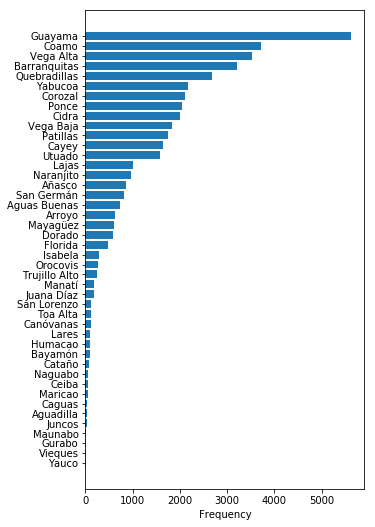

In [34]:
# plot distribution of counts
location_counts.sort_values(inplace=True, ascending=True)
bar_height = 0.2
height = len(location_counts) * bar_height
width = 5
location_counts_Y = pd.np.arange(len(location_counts))
y_label = 'Count'
y_tick_values = map(lambda x: x.decode('utf-8'), location_counts.index)
plt.figure(figsize=(width, height))
plt.barh(location_counts_Y, location_counts)
plt.yticks(location_counts_Y, y_tick_values)
plt.xlabel('Frequency')
plt.show()

Combine location/count data and write to file!!

In [6]:
l_properties = [g.geojson['features'][0]['properties'] for g in l_geocodes]
lon_lat_vals = pd.DataFrame([[g['lng'], g['lat']] for g in l_properties], columns=['lon', 'lat'], index=location_names)
location_plot_df = pd.concat([lon_lat_vals, location_counts], axis=1)
location_plot_df = location_plot_df.rename(columns={0 : 'count'}, inplace=False).dropna(inplace=False)
location_plot_df.to_csv('../../data/facebook-maria/facebook_group_location_data.tsv', sep='\t')

## Map location counts
Take location frequency and put it on a map.

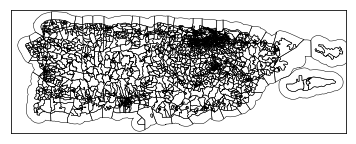

In [66]:
# basic map first
PR_latlon = [[17.819, -67.369], [18.578, -65.20]]
geo_map = Basemap(projection='merc', 
                  llcrnrlat=PR_latlon[0][0], llcrnrlon=PR_latlon[0][1], 
                  urcrnrlat=PR_latlon[1][0], urcrnrlon=PR_latlon[1][1])
PR_shape_file = '../../data/geo_files/PR_shapefiles/tl_2013_72_bg'
geo_map.readshapefile(PR_shape_file, name='PR', drawbounds=True)
plt.show()

(18.3801579, -67.188704)


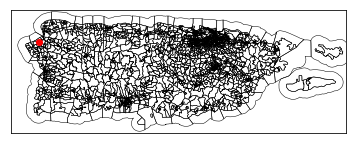

In [89]:
# plot a circle sized according to posts
# at each location
# for l in l_geocodes:
test_geocode = l_geocodes[0]
test_geocode_data = test_geocode.geojson['features'][0]['properties']
test_lat = test_geocode_data['lat']
test_lon = test_geocode_data['lng']
point_color = 'r'
print(test_lat, test_lon)
x,y = geo_map(test_lon, test_lat)
geo_map = Basemap(projection='merc', 
                  llcrnrlat=PR_latlon[0][0], llcrnrlon=PR_latlon[0][1], 
                  urcrnrlat=PR_latlon[1][0], urcrnrlon=PR_latlon[1][1],
                  resolution='l')
geo_map.readshapefile(PR_shape_file, name='PR', drawbounds=True)
geo_map.plot(x, y, color=point_color, marker='o', zorder=5)
plt.show()

Same thing but with all the points.

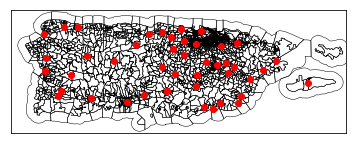

In [107]:
# plot map
geo_map = Basemap(projection='merc', 
                  llcrnrlat=PR_latlon[0][0], llcrnrlon=PR_latlon[0][1], 
                  urcrnrlat=PR_latlon[1][0], urcrnrlon=PR_latlon[1][1],
                  resolution='l')
geo_map.readshapefile(PR_shape_file, name='PR', drawbounds=True)
plot_color = 'r'
# plot one location at a time
for location_name, location_vals in location_plot_df.iterrows():
    l_lon, l_lat, l_count = location_vals
    x,y = geo_map(l_lon, l_lat)
    geo_map.plot(x, y, color=plot_color, marker='o', zorder=5)
plt.show()

Good! It looks like we have decent coverage. Let's see what it looks like when we plot according to post frequency.

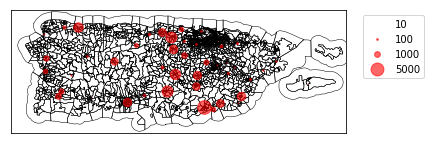

In [34]:
PR_shape_file = '../../data/geo_files/PR_shapefiles/tl_2013_72_bg'
PR_latlon = [[17.819, -67.369], [18.578, -65.20]]
geo_map = Basemap(projection='merc', 
                  llcrnrlat=PR_latlon[0][0], llcrnrlon=PR_latlon[0][1], 
                  urcrnrlat=PR_latlon[1][0], urcrnrlon=PR_latlon[1][1],
                  resolution='l')
geo_map.readshapefile(PR_shape_file, name='PR', drawbounds=True)
# transform count to reasonable size
size_transform = lambda x: x / 30
# plot one location at a time
plot_color = 'r'
alpha = 0.6
for location_name, location_vals in location_plot_df.iterrows():
    l_lon, l_lat, l_count = location_vals
    x,y = geo_map(l_lon, l_lat)
    marker_size = size_transform(l_count)
    geo_map.scatter(x, y, color=plot_color, marker='o', zorder=5, s=marker_size, alpha=alpha)
# plot dummy points for legend
marker_sizes = [10, 100, 1000, 5000]
dummy_x, dummy_y = geo_map(0, 0)
for m in marker_sizes:
    marker_size = size_transform(m)
    geo_map.scatter(dummy_x, dummy_y, color=plot_color, marker='o', zorder=-1, s=marker_size, alpha=alpha, label=m)
plt.legend(loc='upper right', bbox_to_anchor=[1.25, 1.])
plt.show()

TODO: see if adding the comments changes anything significantly.

## Combined stats

In [40]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', 100)
location_group_data = pd.read_csv('../../data/facebook-maria/location_group_data.tsv', sep='\t', index_col=False)
group_counts = pd.read_csv('../../data/facebook-maria/group_counts.tsv', sep='\t', index_col=False)
group_counts = pd.merge(location_group_data, group_counts, on='group_id')
group_counts

,location_name,group_id,group_name,post_count
0,Aguada,1724474021195839,Huracan Maria Anasco y Aguada,433
1,Añasco,1724474021195839,Huracan Maria Anasco y Aguada,433
2,Aguadilla,117529462276443,Huracan Maria Aguadilla,26
3,Aguadilla,1390525734396603,Huracan Maria - Aguadilla - Ceiba Baja y Guerrero,27
4,Ceiba,1390525734396603,Huracan Maria - Aguadilla - Ceiba Baja y Guerrero,27
5,Aguas Buenas,1723084327997466,Aguas Buenas Huracan Maria,723
6,Aguas Buenas,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, area central yabucoa pide ayuda",30
7,Bayamón,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, area central yabucoa pide ayuda",30
8,Comerío,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, area central yabucoa pide ayuda",30
9,Yabucoa,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, area central yabucoa pide ayuda",30
